# Freddie Mac Mortgage Florida Single Family Homes loan deliquency prediction

## Read me
This colab use fm_2014_2018_cleaned_data_for_ML as the model building dataset.

Due to the fact that the size of historical data is too large, the computation will be costly, so we decided to use sample data from 2000-2018. In the sample data, there are 54,895 FL mortgage loans. Within 54,895 FL mortgage loans, 6969 loans had current, or less than 30 days delinquent issues, this mean we only have such data volume to do model training.

Variables used in colab:
1. data: normalize numeric and one-hot encoding caterocial features for regression model usage. After one-hot encoding, the original categorical features are removed
2. data_non_normalize: non-normalize but one-hot encoding caterocial features for tree and XGBoost model
3. feature_analysis_data: feature analysis, feature's issue checking, and EDA usage

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
data = pd.read_csv('/content/fm_2000_2018_cleaned_data_final_deliquent_result.csv')

In [ ]:
# View the first 20 rows
data.head(5)

,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,...,Mortgage Insurance Cancellation Indicator,First Payment Year,First Payment Month,Maturity Year,Maturity Month,Metro Name,Part of MSA,LOAN_SEQUENCE_NUMBER,Month1,target_variable
0,803.0,2012-12,N,2042-11,0,0.0,1.0,P,80.0,19.0,...,9,2012,12,2042,11,Other,N,F12Q10405021,0,0.0
1,745.0,2014-05,N,2044-04,0,0.0,1.0,P,80.0,43.0,...,9,2014,5,2044,4,Other,N,F14Q10118925,0,1.0
2,652.0,2001-11,N,2031-10,0,0.0,1.0,P,80.0,31.0,...,9,2001,11,2031,10,Other,N,F01Q30463920,0,1.0
3,720.0,2004-12,N,2034-11,0,0.0,1.0,P,80.0,16.0,...,9,2004,12,2034,11,Other,N,F04Q40040652,0,0.0
4,738.0,2013-11,N,2043-10,0,0.0,1.0,P,80.0,24.0,...,9,2013,11,2043,10,Other,N,F13Q30255231,0,0.0


## Data Pre-processing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6969 entries, 0 to 6968
Data columns (total 41 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Credit Score                                                  6969 non-null   float64
 1   First Payment Date                                            6969 non-null   object 
 2   First Time Homebuyer Flag                                     6969 non-null   object 
 3   Maturity Date                                                 6969 non-null   object 
 4   Metropolitan Statistical Area (MSA) Or Metropolitan Division  6969 non-null   int64  
 5   Mortgage Insurance Percentage (MI %)                          6969 non-null   float64
 6   Number of Units                                               6969 non-null   float64
 7   Occupancy Status                                              6969 no

# Check NA on features

In [ ]:
# Checking for missing values
data.loc[:, 'Credit Score':'Metro Name'].isnull().sum()
data.fillna({'Mortgage Insurance Cancellation Indicator': 9}, inplace=True)
data.loc[:, 'Credit Score':'Metro Name'].isnull().sum()
data['Program Indicator'].value_counts(normalize=True) ### remove Program Indicator because 9 = Not Available or Not Applicable, and 97.5% is 9

,proportion
Program Indicator,
9,0.97575
H,0.02382
F,0.00043


In [ ]:
# Handle Missing Values
# Drop irrelevant columns based on encoding list
columns_to_remove = [
    'First Payment Date',
    'Maturity Date',
    'Metropolitan Statistical Area (MSA) Or Metropolitan Division',
    'Property State',
    'Postal Code',
    'Loan Sequence Number',
    'Seller Name',
    'Servicer Name',
    'Pre-HARP Loan Sequence Number',
    'Program Indicator',
    'First Payment Year',
    'First Payment Month',
    'Maturity Year',
    'Maturity Month',
    'LOAN_SEQUENCE_NUMBER'
]
data = data.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
data.loc[:, 'Credit Score':'Metro Name'].isnull().sum()

,0
Credit Score,0
First Time Homebuyer Flag,0
Mortgage Insurance Percentage (MI %),0
Number of Units,0
Occupancy Status,0
Original Combined Loan-to-Value (CLTV),0
Original Debt-to-Income (DTI) Ratio,0
Original UPB,0
Original Loan-to-Value (LTV),0
Original Interest Rate,0


In [ ]:
# One-hot encode categorical columns
categorical_columns = [
    'First Time Homebuyer Flag',
    'Occupancy Status',
    'Channel',
    'Prepayment Penalty Mortgage (PPM) Flag',
    'Amortization Type (Formerly Product Type)',
    #'Program Indicator' this feature is deleted in the prior step
    'Property Type',
    'Loan Purpose',
    'Super Conforming Flag',
    'HARP Indicator',
    'Property Valuation Method',
    'Interest Only (I/O) Indicator',
    'Mortgage Insurance Cancellation Indicator',
    'Metro Name',
    'Part of MSA'
]

# Create on-hot-encoding dataframe
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_columns]))
# Assigned column names back to the on-hot-encoding dataframe
encoded_data.columns = encoder.get_feature_names_out(categorical_columns)

# Merge encoded data back

data = pd.concat([data.drop(columns=categorical_columns), encoded_data], axis=1)
data_non_normalize = data.copy()
feature_analysis_data = data.copy()

In [ ]:
# Normalizing numerical columns
numerical_columns = [
    'Credit Score', ### treat it as numeric and normalize
    'Mortgage Insurance Percentage (MI %)',
    'Number of Units',
    'Original Combined Loan-to-Value (CLTV)',
    'Original Debt-to-Income (DTI) Ratio',
    'Original UPB',
    'Original Loan-to-Value (LTV)',
    'Original Interest Rate',
    'Original Loan Term',
    'Number of Borrowers'
]
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Drop orignal categorical columns after one-hot encoding
data = data.drop(columns=categorical_columns, errors='ignore')

In [ ]:
data['Month1'] = data['Month1'].astype(str).str.strip()
# keep only Month1 = 1 because we can't predct loans that have deliquented
#data = data[(data['Month1'] != '1') & (data['Month1'] != 'RA')]

In [ ]:
data

,target_variable
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
6964,0.0
6965,0.0
6966,0.0
6967,0.0


data_non_normalize is for tree and XGBoost model because normalization is not needed

In [ ]:
data_non_normalize.head()
data_non_normalize = data_non_normalize[(data_non_normalize['Month1'] != '1') & (data_non_normalize['Month1'] != 'RA')]

# Feature analysis and selection

In [ ]:
feature_analysis_data = pd.read_csv('/content/fm_2000_2018_cleaned_data_final_deliquent_result.csv')
feature_analysis_data.fillna({'Mortgage Insurance Cancellation Indicator': 9}, inplace=True)
feature_analysis_data = feature_analysis_data.drop(columns=columns_to_remove, errors='ignore')
feature_analysis_data.loc[:, 'Credit Score':'Metro Name'].isnull().sum()

<ipython-input-13-067545c9b98a>:1: DtypeWarning: Columns (26,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_analysis_data = pd.read_csv('/content/fm_2000_2018_cleaned_data_final_deliquent_result.csv')


,0
Credit Score,0
First Time Homebuyer Flag,0
Mortgage Insurance Percentage (MI %),0
Number of Units,0
Occupancy Status,0
Original Combined Loan-to-Value (CLTV),0
Original Debt-to-Income (DTI) Ratio,0
Original UPB,0
Original Loan-to-Value (LTV),0
Original Interest Rate,0


In [ ]:
feature_analysis_data['loan_final_deliquency_status'].value_counts(normalize=True)
# If loan_final_deliquency_status is Paid, then 0; otherwise, it's deliquent noted as 1
feature_analysis_data['loan_final_deliquency_status'] = feature_analysis_data['loan_final_deliquency_status'].apply(
    lambda x: 0 if x == "Paid" else 1
)
# Ensure the target variable 'loan_final_deliquency_status' is binary
# Convert to integer if not already binary
feature_analysis_data['loan_final_deliquency_status'] = feature_analysis_data['loan_final_deliquency_status'].astype(int)

In [ ]:
# Separate numeric features
numeric_features = feature_analysis_data.select_dtypes(include=['int64', 'float64']).columns

# Exclude the target variable itself from the numeric features
numeric_features = numeric_features.drop('loan_final_deliquency_status', errors='ignore')

# Compute Pearson correlation for numeric features against the target variable
correlation_with_target = feature_analysis_data[numeric_features].corrwith(
    feature_analysis_data['loan_final_deliquency_status']
)

# Sort correlations in descending order for better interpretation
correlation_sorted = correlation_with_target.sort_values(ascending=False)
correlation_sorted

,0
Original Debt-to-Income (DTI) Ratio,0.089249
Original Loan-to-Value (LTV),0.058643
Original Combined Loan-to-Value (CLTV),0.057211
Original UPB,0.015500
Original Loan Term,0.008135
Mortgage Insurance Percentage (MI %),0.001035
Number of Units,0.000169
Credit Score,-0.014677
Number of Borrowers,-0.024650
Property Valuation Method,-0.181447


# Data Issue
1. multuicollinearity: CLTV & original interest rate (Multicollinearity is considered significant if the absolute correlation is above 0.8 or 0.9)

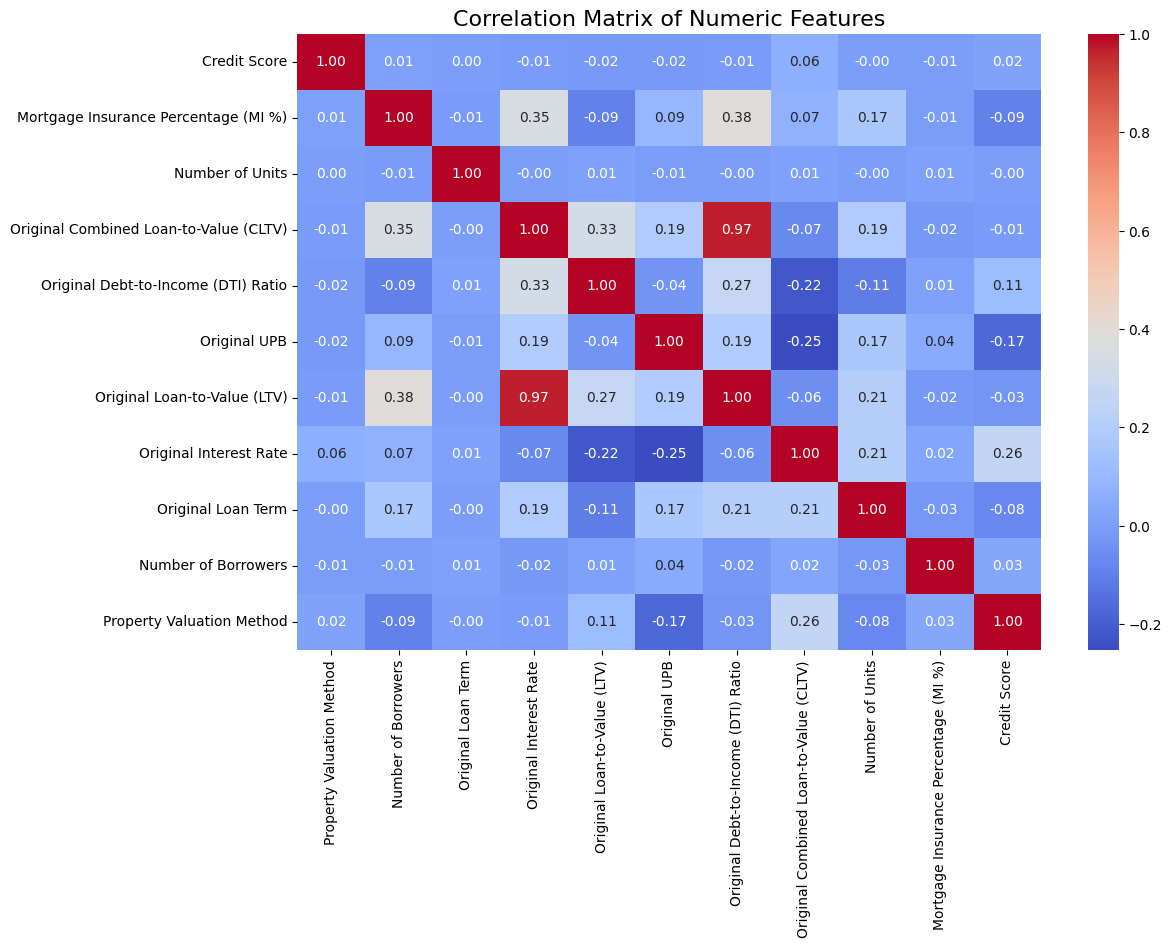

[('Original Combined Loan-to-Value (CLTV)', 'Original Loan-to-Value (LTV)', 0.9657745831334379)]


In [ ]:
# Compute the correlation matrix for numeric features
numeric_features = feature_analysis_data[numeric_features]
correlation_matrix = numeric_features.corr()


# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
                      xticklabels=correlation_matrix.columns[::-1],  # Reverse the x-axis labels
                      yticklabels=correlation_matrix.columns)  # Keep the y-axis labels as is
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

# Identify potential multicollinearity issues
# Multicollinearity is considered significant if the absolute correlation is above 0.8 or 0.9.
threshold = 0.8
multicollinearity_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            multicollinearity_pairs.append(
                (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            )

# Output pairs with potential multicollinearity issues
print(multicollinearity_pairs)

In [ ]:
# check outliers


In [ ]:
data_non_normalize['loan_']

Index(['Credit Score', 'Mortgage Insurance Percentage (MI %)',
       'Number of Units', 'Original Combined Loan-to-Value (CLTV)',
       'Original Debt-to-Income (DTI) Ratio', 'Original UPB',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate',
       'Original Loan Term', 'Number of Borrowers',
       ...
       'Metro Name_Palm Bay-Melbourne-Titusville', 'Metro Name_Palm Coast',
       'Metro Name_Panama City-Lynn Haven-Panama City Beach',
       'Metro Name_Pensacola-Ferry Pass-Brent', 'Metro Name_Port St. Lucie',
       'Metro Name_Punta Gorda', 'Metro Name_Sebastian-Vero Beach',
       'Metro Name_Tallahassee', 'Metro Name_Tampa-St. Petersburg-Clearwater',
       'Part of MSA_Y'],
      dtype='object', length=171)